In [2]:
import torch 
import numpy as np
import pandas as pd
import transformers
import random
import json
import datasets
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType
from transformers import AutoTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq
import evaluate

/home/samuel/.conda/envs/text/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data preprocess

In [4]:
with open("./data/train.json","r") as f:
    data = f.readlines()

In [5]:
train_data = []
for d in data:
    try:
        train_data.append(eval(d))
    except Exception as e:
        print(d)

{"body":null,"title":"Prince William Just Followed in Mom Princess Diana's Footsteps with This Emotional Trip"}

{"body":null,"title":"The one part of life that means more than friends, pets, faith and jobs"}

{"body":null,"title":"This is LA's secret parking-lot pizza"}

{"body":null,"title":"Meet a cuddly baby dugong named Marium"}

{"body":null,"title":"Madonna - God Control (Official Music Video)"}

{"body":null,"title":"How to Make a Flip-Down Coat Rack"}

{"body":null,"title":"The best OTC pain reliever for every kind of ache"}

{"body":null,"title":"Nadal plays down row over Wimbledon seeding"}

{"body":null,"title":"2020 Jeep Gladiator Towing Test"}

{"body":null,"title":"Americans agree on one part of the U.S.-Russia relationship. But just one."}

{"body":null,"title":"How does the 2020 Jeep Gladiator stack up against the competition?"}

{"body":null,"title":"20 most commonly overlooked cancer symptoms"}

{"body":null,"title":"'I'm not ready to die': Paige Winter, teen that su

In [6]:
df = pd.DataFrame(train_data)
df['body'] = df['body'].str.encode('utf-8', 'replace').str.decode('utf-8')
df['title'] = df['title'].str.encode('utf-8', 'replace').str.decode('utf-8')

In [7]:
df['title_length'] = df['title'].apply(lambda x : len(x.split()))
df['body_length'] = df['body'].apply(lambda x : len(x.split()))

In [9]:
mask1 =(df['body_length']>10) & (df['body_length']<10000)
mask2 = df['body']!=df['title']
mask3 = (df['title_length']<df['body_length'])
df_filtered = df[mask2&mask1&mask3].reset_index(drop=True)

In [10]:
df_filtered[['body_length']].describe()

,body_length
count,96814.000000
mean,564.406935
std,660.858417
min,11.000000
25%,183.000000
50%,383.000000
75%,722.000000
max,9993.000000


<Axes: ylabel='Frequency'>

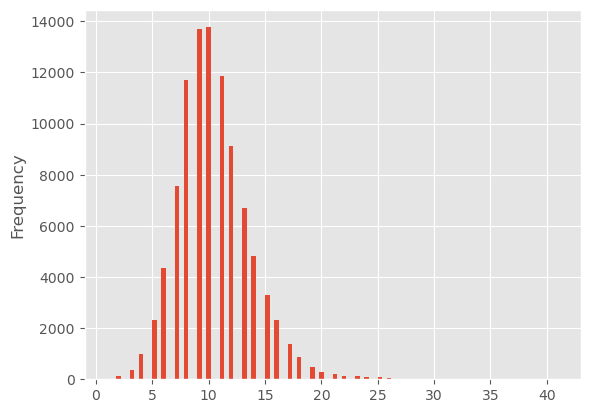

In [11]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
df_filtered['title_length'].plot(kind="hist",bins=100)

In [12]:
import html
df_filtered['body'] = df_filtered['body'].apply(lambda x: html.unescape(x))
df_filtered['title'] = df_filtered['title'].apply(lambda x: html.unescape(x))

In [13]:
df_filtered['body']

0        Only FIVE internationals allowed, count em, FI...
1        WASHINGTON -- Senate Majority Leader Mitch McC...
2        NORTH HIGHLANDS (CBS13)   Fire damaged a home ...
3        Meghan McCain is speaking out after a journali...
4        1714: George I becomes King Georg Ludwig, Elec...
                               ...                        
96809    CHICAGO (CBS)  It's a battle that one south su...
96810    Check out the news! Dak Prescott loves Amari C...
96811    (Reuters) - Shares of Tesla Inc fell 1.7% on T...
96812    Cleveland is rolling out the red carpet as mor...
96813    Charlotte Hornets GM Mitch Kupchak isn't doing...
Name: body, Length: 96814, dtype: object

In [15]:
dataset = datasets.Dataset.from_pandas(df_filtered)
all_dataset = dataset.train_test_split(train_size=0.8, seed=42)
all_dataset['val'] = all_dataset.pop('test')

In [16]:
all_dataset['val']

Dataset({
    features: ['body', 'title', 'title_length', 'body_length'],
    num_rows: 19363
})

In [17]:
def preprocess(data):
    model_inputs = tokenizer(data["body"],padding=True, max_length=1024,truncation=True, return_tensors='pt')

    labels = tokenizer(text_target=data["title"], padding=True, max_length=40, truncation=True, return_tensors='pt')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [18]:
model_name_or_path = "facebook/bart-large"
peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM,inference_mode = False,r=8,lora_alpha=32, lora_dropout=0.1)

model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
model = get_peft_model(model,peft_config)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model.print_trainable_parameters()
model

trainable params: 1179648 || all params: 407471104 || trainable%: 0.2895047006817936


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): BartForConditionalGeneration(
      (model): BartModel(
        (shared): Embedding(50265, 1024, padding_idx=1)
        (encoder): BartEncoder(
          (embed_tokens): Embedding(50265, 1024, padding_idx=1)
          (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
          (layers): ModuleList(
            (0-11): 12 x BartEncoderLayer(
              (self_attn): BartAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(
                  in_features=1024, out_features=1024, bias=True
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features

In [23]:
all_dataset['train'] = all_dataset['train'].map(preprocess,batched=True,remove_columns=all_dataset['train'].column_names)
all_dataset['val'] = all_dataset['val'].map(preprocess,batched=True,remove_columns=all_dataset['val'].column_names)

In [24]:
len(all_dataset['train'] ),len(all_dataset['val'] )

(77451, 19363)

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,model ="facebook/bart-large" )

In [26]:

metric_rouge = evaluate.load("rouge", rouge_types=["rouge1", "rouge2", "rougeL"])
metric_bertscore = evaluate.load("bertscore")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    rouge_result = metric_rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bertscore_result = metric_bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    output = {k: round(v, 4) for k, v in rouge_result.items()}
    output["bertscore"] = np.mean(bertscore_result['precision'])
    output["gen_len"] = np.mean(prediction_lens)
    return output

In [27]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
training_args = Seq2SeqTrainingArguments(
    output_dir="version1_bart_large_lora_30epoch_lr1e-3",
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=4,
    num_train_epochs=3,
    predict_with_generate=True,
    # remove_unused_columns=False,
    fp16=True,
    save_strategy ="steps",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end =True,
    save_steps = 500,
    logging_steps = 500,
    eval_steps = 500,
    eval_delay =200,
    logging_dir = 'logs',
    metric_for_best_model ="rougeL"
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=all_dataset['train'],
    eval_dataset=all_dataset['val'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/home/samuel/.conda/envs/text/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bertscore,Gen Len
500,5.606700,4.835441,0.438800,0.260100,0.399300,0.399500,0.898156,16.880287
1000,5.304100,5.260795,0.329800,0.180700,0.298900,0.298900,0.879990,16.620100
1500,5.263900,4.849748,0.445100,0.269100,0.405900,0.406000,0.897920,17.624697
2000,5.248700,4.835257,0.451400,0.273500,0.412800,0.412800,0.899632,17.499716
2500,5.255000,4.852485,0.426600,0.252500,0.390100,0.390300,0.885041,16.887724
3000,5.257100,4.826069,0.457800,0.277700,0.418100,0.418100,0.902552,17.239426
3500,5.237300,4.828297,0.459000,0.278600,0.417800,0.417800,0.901077,17.823994
4000,5.300800,4.828673,0.450400,0.271100,0.412700,0.412700,0.900381,16.680215
4500,5.264000,4.812815,0.455500,0.276300,0.416700,0.416800,0.901490,17.080514
5000,5.265900,4.816874,0.458000,0.277600,0.418200,0.418200,0.902952,16.570469


In [31]:
trainer.state.best_model_checkpoint

'version1_bart_large_lora_30epoch_lr1e-3/checkpoint-28000'

In [42]:
model.save_pretrained("bart_large_lora")

In [54]:
from peft import PeftModel, PeftConfig
peft_model_id = "bart_large_lora"
config = PeftConfig.from_pretrained(peft_model_id)
model = BartForConditionalGeneration.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
inputs = tokenizer(dataset[-120]['body'], return_tensors="pt").input_ids
outputs  = model.generate(input_ids=inputs, max_new_tokens=30)
tokenizer.decode(outputs[0], skip_special_tokens=True)

"'Burn in hell, you sorry SOBs': Cone Health executive pens personal attack in email to state leaders"

In [55]:
dataset[-120]['title']

"'Burn in hell, you sorry SOBs': Cone Health executive pens personal attack in email to state leaders"

In [1]:
l = []
train_loss= {}
for obj in trainer.state.log_history:
    train_loss['loss'] =train_loss.get("loss",[])
    train_loss['step'] =train_loss.get("step",[])
    if "eval_loss" in obj.keys():
        l.append(obj)
    else:
        train_loss['loss'].append(obj['loss'])
        
        train_loss['step'].append(obj['step'])

<Axes: title={'center': 'train loss(per 500 steps)'}>

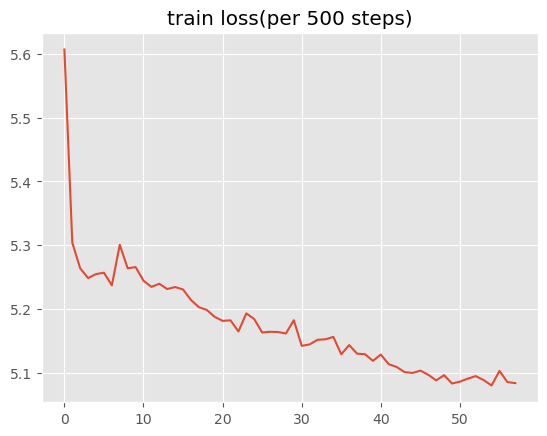

In [56]:
df = pd.DataFrame(train_loss)
df.loc[:,"loss"].plot(title="train loss(per 500 steps)")


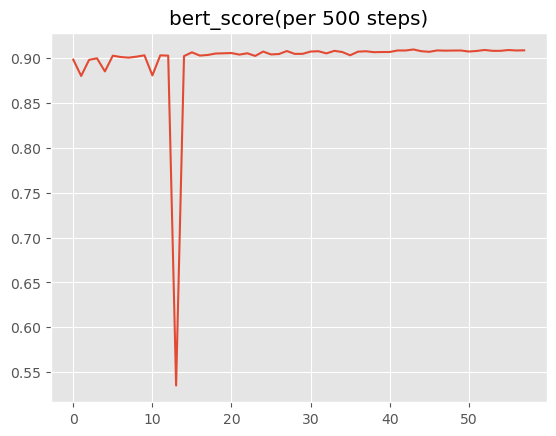

In [57]:
dic = {}
for d in l:
    for k,v in d.items():
        dic[k] = dic.get(k,[])
        dic[k].append(v)
df = pd.DataFrame(dic)
ax = df.loc[:,"eval_bertscore"].plot(title="bert_score(per 500 steps)")

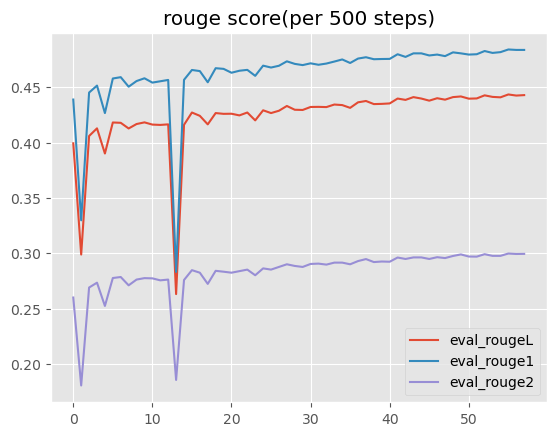

In [58]:
ax = df.loc[:,["eval_rougeL","eval_rouge1","eval_rouge2"]].plot(title="rouge score(per 500 steps)")